In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, QuantileTransformer, RobustScaler

import matplotlib.pyplot as plt
from scipy.stats import kurtosis, normaltest, probplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
folder_path = os.path.join("..", "Filtered datasets")
var_names = [] 

for filename in os.listdir(folder_path):
    name = filename.lower().replace('.csv', '')
    print(name)
    var_names.append(name)

benign
bot_infiltration
dos
ftp_ssh_patator
heartbleed
portscan
web


In [3]:
for filename in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, filename))
    cols_to_float = [col for col in df.columns if col != 'Label']
    df[cols_to_float] = df[cols_to_float].astype('float64')
    var_name = filename.lower().replace('.csv', '')
    globals()[var_name] = df

dataframes = [globals()[name] for name in var_names]

In [4]:
for name in var_names:
    df = globals()[name]
    print(f"\n=== Describe для `{name}` ===")
    print(df.describe().to_string())


=== Describe для `benign` ===
       Flow Bytes/s  Flow Packets/s  Average Packet Size  Down/Up Ratio  Packet Length Mean  Packet Length Std  Min Packet Length  Max Packet Length  Flow IAT Mean  Flow IAT Std  Fwd IAT Mean  Bwd IAT Mean  SYN Flag Count  FIN Flag Count  RST Flag Count  PSH Flag Count  ACK Flag Count   Active Mean     Idle Mean  Subflow Fwd Packets  Subflow Bwd Packets
count  2.268589e+06    2.268589e+06         2.268589e+06   2.268589e+06        2.268589e+06       2.268589e+06       2.268589e+06       2.268589e+06   2.268589e+06  2.268589e+06  2.268589e+06  2.268589e+06    2.268589e+06    2.268589e+06    2.268589e+06    2.268589e+06    2.268589e+06  2.268589e+06  2.268589e+06         2.268589e+06         2.268589e+06
mean   1.781885e+06    6.491657e+04         1.234778e+02   7.009701e-01        1.086605e+02       1.471520e+02       2.026009e+01       4.913648e+02   9.100121e+05  1.578066e+06  1.902760e+06  1.784573e+06    5.483100e-02    1.795521e-02    2.997458e-04    

In [5]:
seen = set()
skew_dict = {}

for df in dataframes:
    for col in df.columns:
        if col not in seen:
            skew_val = df[col].skew()
            skew_dict[col] = skew_val
            seen.add(col)

skew_df = (
    pd.DataFrame.from_dict(skew_dict, orient='index', columns=['skew'])
      .sort_index()
)

skew_df

,skew
ACK Flag Count,0.943374
Active Mean,45.508344
Average Packet Size,3.912625
Bwd Avg Bytes/Bulk,0.000000
Bwd Header Length,4.685663
Bwd IAT Mean,8.255471
Bwd IAT Std,12.979811
Bwd Packets/s,53.466079
Bwd URG Flags,0.000000
Down/Up Ratio,13.706292


In [4]:
# 1) log1p: сильна права асиметрія (skew > 1)
log1p_features = [
    'Active Mean',
    'Average Packet Size',
    'Bwd Header Length',
    'Bwd IAT Mean',
    'Bwd IAT Std',
    'Down/Up Ratio',
    'Flow Bytes/s',
    'Flow Duration',
    'Flow IAT Mean',
    'Flow IAT Min',
    'Flow IAT Std',
    'Flow Packets/s',
    'Fwd Header Length',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Fwd PSH Flags',
    'Fwd Packets/s',
    'Idle Mean',
    'Max Packet Length',
    'Min Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Packet Length Variance'
]

# 2) Yeo–Johnson: сильна ліва асиметрія (skew < –1), помірна права асиметрія (0.5 < skew ≤ 1), або наявність нулів/від’ємних
yeo_johnson_features = [
    'Total Length of Fwd Packets'
    'Fwd Packet Length Max'
]

# 3) QuantileTransformer: надзвичайно важкі хвости (skew > 50)
quantile_transform_features = [
    'Bwd Packets/s',
    'Subflow Bwd Packets',
    'Subflow Fwd Packets',
    'Total Backward Packets',
    'Total Fwd Packets'
]

# 4) За рештою ознак (|skew| ≤ 0.5) достатньо RobustScaler або залишити без трансформації:
robust_features = [
    'Bwd Avg Bytes/Bulk',
    'Bwd URG Flags',
    'Flow IAT Max',
    'Fwd Avg Bytes/Bulk',
    'Fwd Avg Packets/Bulk',
    'Fwd IAT Min',
    'Fwd Packet Length Min',
]

In [5]:
log1p_tf = FunctionTransformer(np.log1p, validate=False)
yeojohnson_tf = PowerTransformer(method='yeo-johnson', standardize=False)
quantile_tf = QuantileTransformer(output_distribution='normal', random_state=0)
robust_tf = RobustScaler()

In [6]:
transformed_dataframes = []

for df in dataframes:
    df_t = df.copy()
    
    def apply(df, features, transformer, fit=True):
        present = [f for f in features if f in df.columns]
        if not present:
            return
        if fit:
            df.loc[:, present] = transformer.fit_transform(df[present])
        else:
            df.loc[:, present] = transformer.transform(df[present])
    
    apply(df_t, log1p_features, log1p_tf, fit=False)
    apply(df_t, yeo_johnson_features, yeojohnson_tf, fit=True)
    apply(df_t, quantile_transform_features, quantile_tf, fit=True)
    apply(df_t, robust_features, robust_tf, fit=True)
    
    transformed_dataframes.append(df_t)

c:\Users\dubst\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
def plot_histograms_and_qq(
    df_before,
    df_after,
    feature
):

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    x_before = df_before[feature]
    x_after = df_after[feature]

    ax_hist_before, ax_hist_after = axes[0]
    ax_qq_before, ax_qq_after = axes[1]

    ax_hist_before.hist(x_before, bins=50)
    ax_hist_before.set_title(f'{feature} — before transformation')
    ax_hist_before.set_xlabel(feature)
    ax_hist_before.set_ylabel('Count')

    ax_hist_after.hist(x_after, bins=50)
    ax_hist_after.set_title(f'{feature} — after transformation')
    ax_hist_after.set_xlabel(feature)
    ax_hist_after.set_ylabel('Count')

    probplot(x_before, dist='norm', plot=ax_qq_before)
    ax_qq_before.set_title(f'Q–Q plot of {feature} before')

    probplot(x_after, dist='norm', plot=ax_qq_after)
    ax_qq_after.set_title(f'Q–Q plot of {feature} after')

    plt.tight_layout()
    plt.show()

    return fig, axes

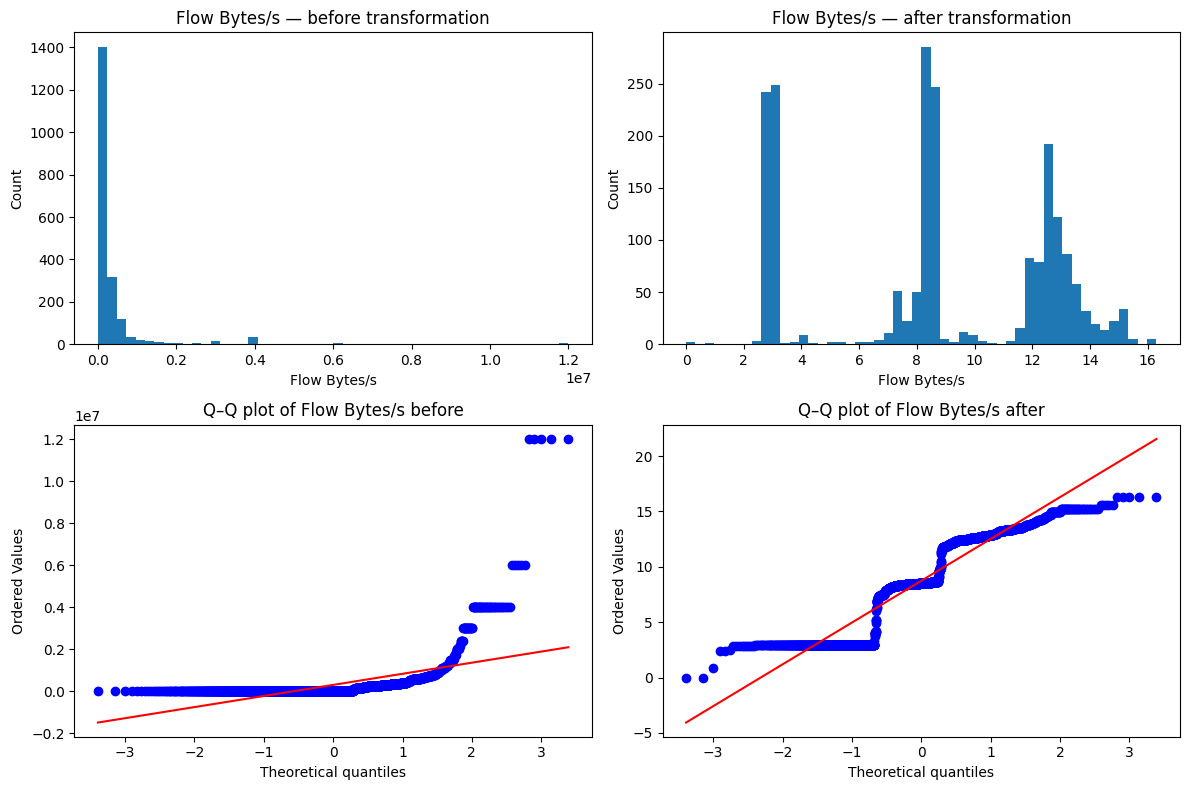

(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Flow Bytes/s — before transformation'}, xlabel='Flow Bytes/s', ylabel='Count'>,
         <Axes: title={'center': 'Flow Bytes/s — after transformation'}, xlabel='Flow Bytes/s', ylabel='Count'>],
        [<Axes: title={'center': 'Q–Q plot of Flow Bytes/s before'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>,
         <Axes: title={'center': 'Q–Q plot of Flow Bytes/s after'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]],
       dtype=object))

In [39]:
plot_histograms_and_qq(dataframes[1], transformed_dataframes[1], 'Flow Bytes/s')

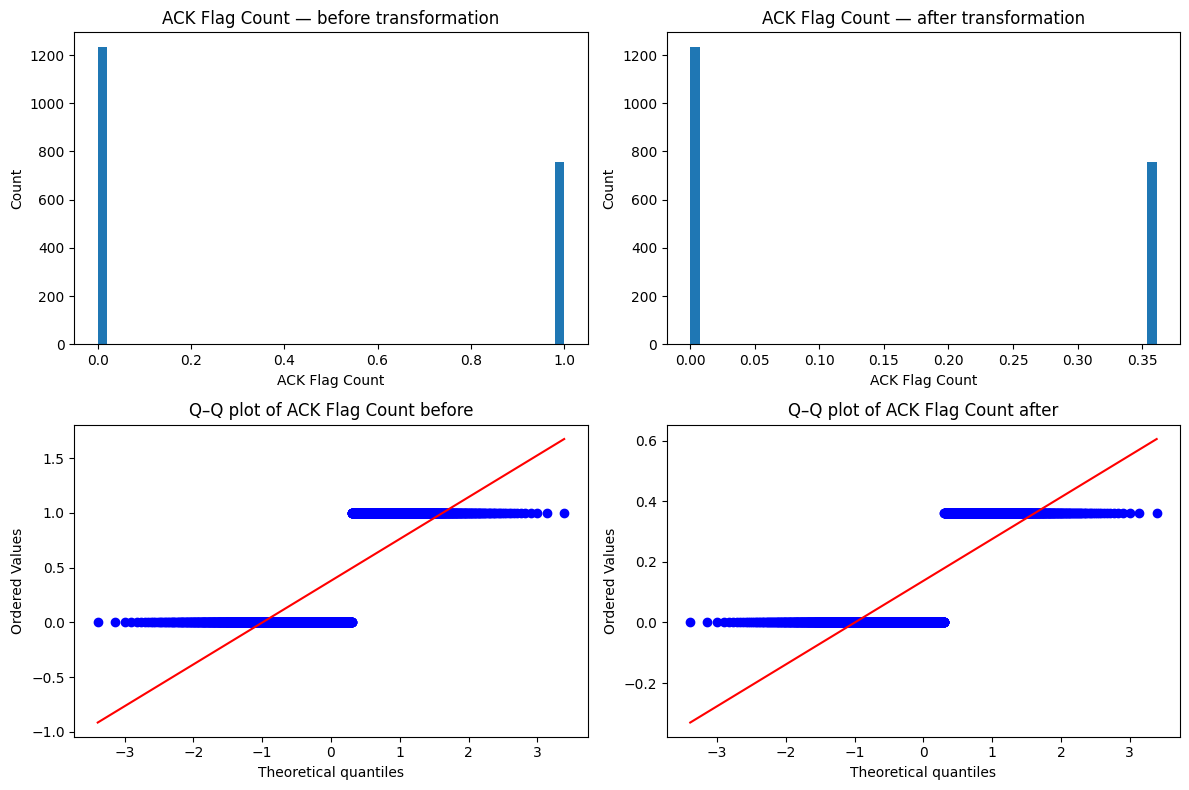

(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'ACK Flag Count — before transformation'}, xlabel='ACK Flag Count', ylabel='Count'>,
         <Axes: title={'center': 'ACK Flag Count — after transformation'}, xlabel='ACK Flag Count', ylabel='Count'>],
        [<Axes: title={'center': 'Q–Q plot of ACK Flag Count before'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>,
         <Axes: title={'center': 'Q–Q plot of ACK Flag Count after'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]],
       dtype=object))

In [40]:
plot_histograms_and_qq(dataframes[1], transformed_dataframes[1], 'ACK Flag Count')

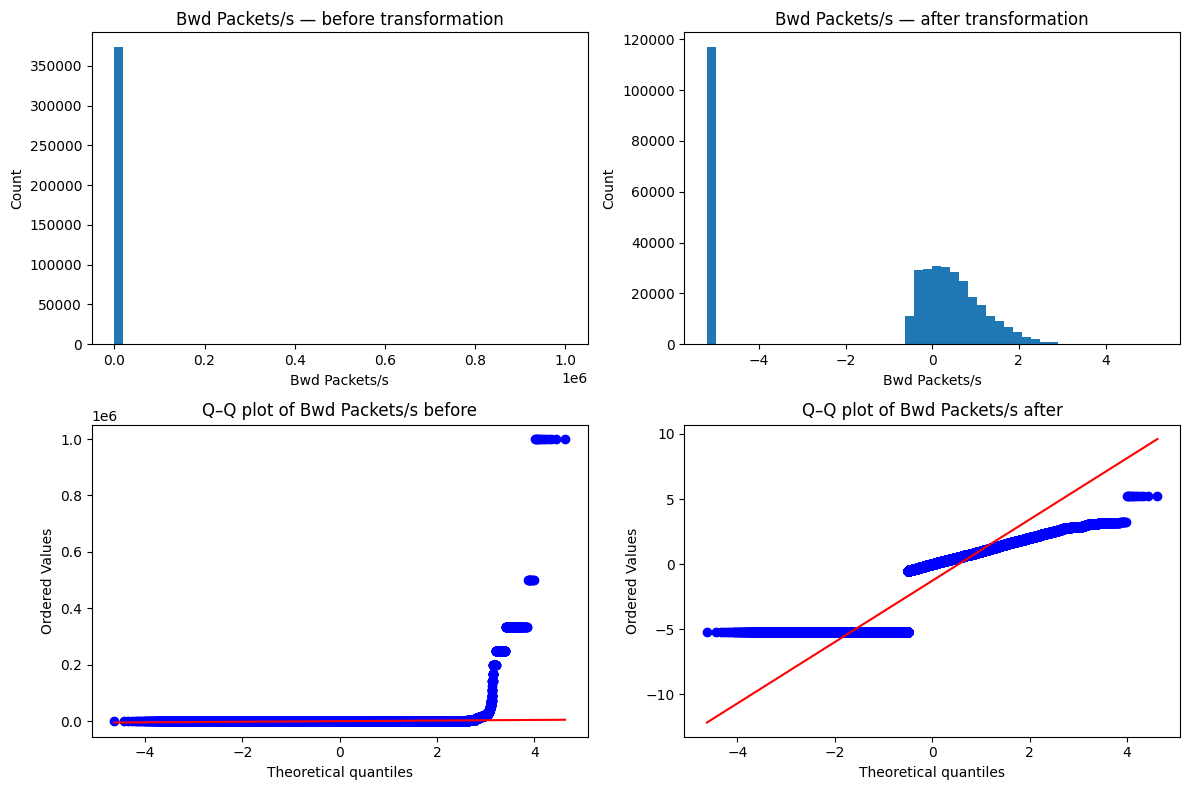

(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Bwd Packets/s — before transformation'}, xlabel='Bwd Packets/s', ylabel='Count'>,
         <Axes: title={'center': 'Bwd Packets/s — after transformation'}, xlabel='Bwd Packets/s', ylabel='Count'>],
        [<Axes: title={'center': 'Q–Q plot of Bwd Packets/s before'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>,
         <Axes: title={'center': 'Q–Q plot of Bwd Packets/s after'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]],
       dtype=object))

In [42]:
plot_histograms_and_qq(dataframes[2], transformed_dataframes[2], 'Bwd Packets/s')

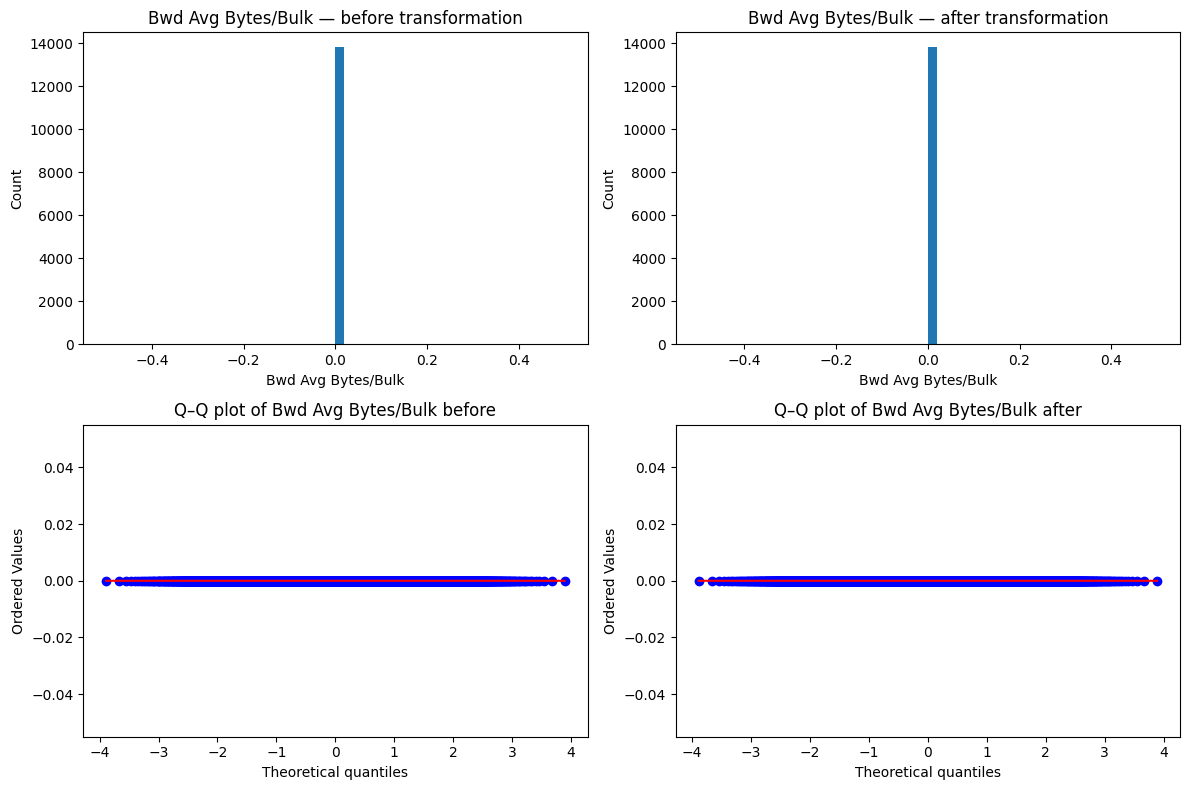

(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Bwd Avg Bytes/Bulk — before transformation'}, xlabel='Bwd Avg Bytes/Bulk', ylabel='Count'>,
         <Axes: title={'center': 'Bwd Avg Bytes/Bulk — after transformation'}, xlabel='Bwd Avg Bytes/Bulk', ylabel='Count'>],
        [<Axes: title={'center': 'Q–Q plot of Bwd Avg Bytes/Bulk before'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>,
         <Axes: title={'center': 'Q–Q plot of Bwd Avg Bytes/Bulk after'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]],
       dtype=object))

In [44]:
plot_histograms_and_qq(dataframes[3], transformed_dataframes[3], 'Bwd Avg Bytes/Bulk')

In [12]:
seen = set()
stats_dict = {}

for df in dataframes:
    for col in df.columns:
        if col not in seen:
            series = df[col]
            skew_val = series.skew()
            kurt_val = kurtosis(series)
            k2_stat, p_val = normaltest(series)
            
            stats_dict[col] = {
                'skew': skew_val,
                'kurtosis': kurt_val,
                'k2_stat': k2_stat,
                'p_value': p_val
            }
            seen.add(col)

stats_df = (
    pd.DataFrame.from_dict(stats_dict, orient='index')
      .sort_index()
)

stats_df

C:\Users\dubst\AppData\Local\Temp\ipykernel_12840\2316089316.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  k2_stat, p_val = normaltest(series)


,skew,kurtosis,k2_stat,p_value
ACK Flag Count,0.943374,-1.110047e+00,1.248223e+06,0.0
Active Mean,45.508344,4.940701e+03,6.924386e+06,0.0
Average Packet Size,3.912625,2.106423e+01,1.861728e+06,0.0
Bwd Avg Bytes/Bulk,0.000000,NaN,NaN,NaN
Bwd Header Length,4.685663,2.000736e+01,2.016661e+03,0.0
Bwd IAT Mean,8.255471,7.608826e+01,3.114698e+06,0.0
Bwd IAT Std,12.979811,1.864970e+02,3.589071e+03,0.0
Bwd Packets/s,53.466079,4.005767e+03,1.203871e+06,0.0
Bwd URG Flags,0.000000,NaN,NaN,NaN
Down/Up Ratio,13.706292,1.970320e+03,4.372284e+06,0.0


In [7]:
seen = set()
stats_dict = {}

for df in transformed_dataframes:
    for col in df.columns:
        if col not in seen:
            series = df[col]
            skew_val = series.skew()
            kurt_val = kurtosis(series)
            k2_stat, p_val = normaltest(series)
            
            stats_dict[col] = {
                'skew': skew_val,
                'kurtosis': kurt_val,
                'k2_stat': k2_stat,
                'p_value': p_val
            }
            seen.add(col)

stats_df = (
    pd.DataFrame.from_dict(stats_dict, orient='index')
      .sort_index()
)

stats_df

C:\Users\dubst\AppData\Local\Temp\ipykernel_7016\806436407.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  k2_stat, p_val = normaltest(series)


,skew,kurtosis,k2_stat,p_value
ACK Flag Count,0.943374,-1.110047,1.248223e+06,0.000000e+00
Active Mean,1.975499,2.046630,7.664982e+05,0.000000e+00
Average Packet Size,-0.765666,-0.255998,1.846507e+05,0.000000e+00
Bwd Avg Bytes/Bulk,0.000000,NaN,NaN,NaN
Bwd Header Length,2.883331,13.713911,1.416652e+03,2.387585e-308
Bwd IAT Mean,1.155154,-0.246237,3.388555e+05,0.000000e+00
Bwd IAT Std,-0.245920,-1.584752,1.074722e+04,0.000000e+00
Bwd Packets/s,-0.655713,-1.338368,1.390408e+07,0.000000e+00
Bwd URG Flags,0.000000,NaN,NaN,NaN
Down/Up Ratio,0.006800,0.204009,3.266786e+03,0.000000e+00


In [7]:
features_to_bin = [
    'Flow IAT Min',
    'Fwd Header Length',
    'Fwd PSH Flags',
    'Packet Length Variance',
    'Total Backward Packets',
    'Total Fwd Packets'
]

def bin_features(dataframes, features, n_bins=5):
    binned = []
    for df in dataframes:
        df_bin = df.copy()
        for feat in features:
            if feat not in df_bin.columns:
                continue
            df_bin[f'{feat}_bin'] = pd.qcut(
                df_bin[feat],
                q=n_bins,
                labels=False,
                duplicates='drop'
            )
        binned.append(df_bin)

    return binned

binned_df = bin_features(transformed_dataframes, features_to_bin)

In [18]:
binned_df[4].head()

,Flow Bytes/s,Flow Packets/s,Average Packet Size,Down/Up Ratio,Packet Length Mean,Packet Length Std,Min Packet Length,Max Packet Length,Flow IAT Mean,Flow IAT Std,...,dow,hour,dow_sin,dow_cos,hour_sin,hour_cos,Fwd Packet Length Max,Fwd Packet Length Min,Fwd IAT Min,Total Length of Fwd Packets
0,11.057423,3.637542,7.447118,0.0,7.446892,7.889980,0.0,9.762903,10.204902,12.070406,...,2.0,12.0,0.974928,-0.222521,1.224647e-16,-1.0,517.0,0.0,0.0,8299.0
1,11.100031,3.740112,7.385296,0.0,7.385092,7.789492,0.0,9.580593,10.099682,11.937561,...,2.0,12.0,0.974928,-0.222521,1.224647e-16,-1.0,5792.0,0.0,0.0,13712.0
2,11.100035,3.744493,7.380632,0.0,7.380429,7.776078,0.0,9.475240,10.095194,11.935559,...,2.0,12.0,0.974928,-0.222521,1.224647e-16,-1.0,4344.0,0.0,0.0,12264.0
3,11.099725,3.733626,7.391081,0.0,7.390876,7.795106,0.0,9.762903,10.106327,11.939798,...,2.0,12.0,0.974928,-0.222521,1.224647e-16,-1.0,1448.0,0.0,0.0,9368.0
4,11.100045,3.734339,7.391037,0.0,7.390832,7.795183,0.0,9.675897,10.105597,11.938967,...,2.0,12.0,0.974928,-0.222521,1.224647e-16,-1.0,4344.0,0.0,0.0,12264.0


In [ ]:
def compute_spearman(dataframes):
    combined = pd.concat(dataframes, axis=0)
    numeric_global = combined.select_dtypes(include=[np.number])
    global_corr = numeric_global.corr(method='spearman')

    per_df_corrs = []
    for df in dataframes:
        numeric_df = df.select_dtypes(include=[np.number])
        per_df_corrs.append(numeric_df.corr(method='spearman'))
    
    return global_corr, per_df_corrs

spearman_global, spearman_list = compute_spearman(transformed_dataframes)

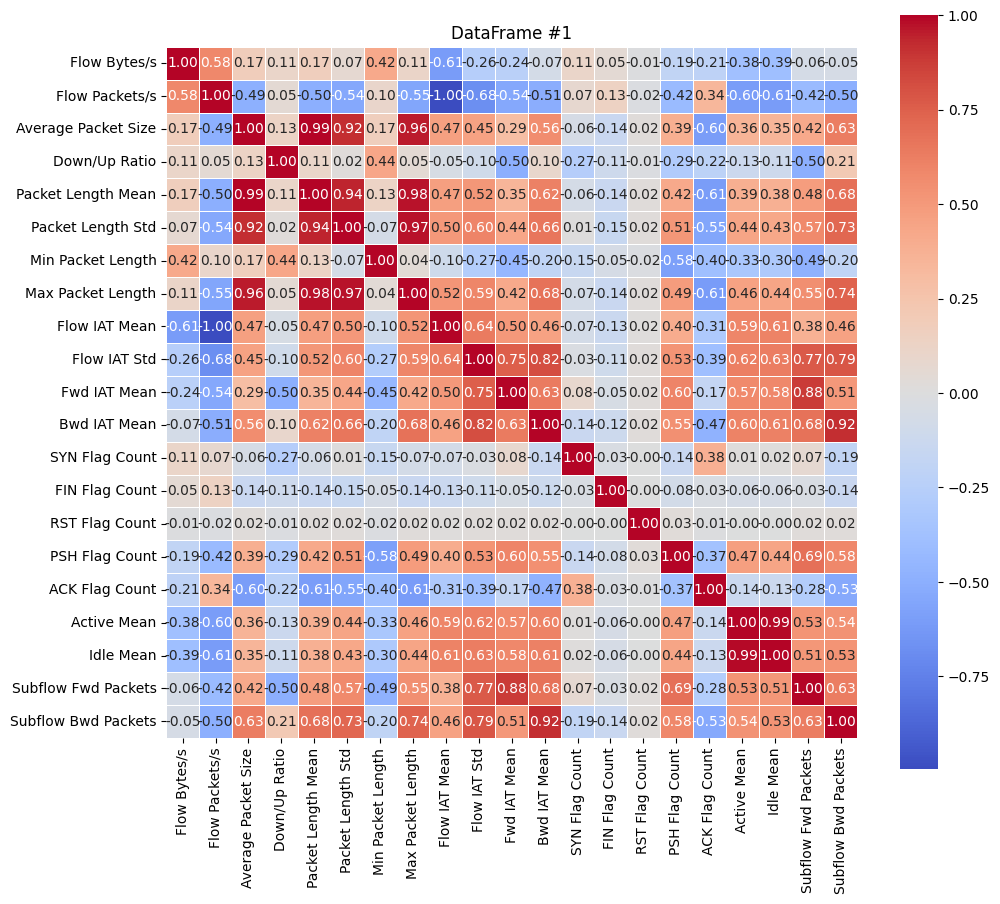

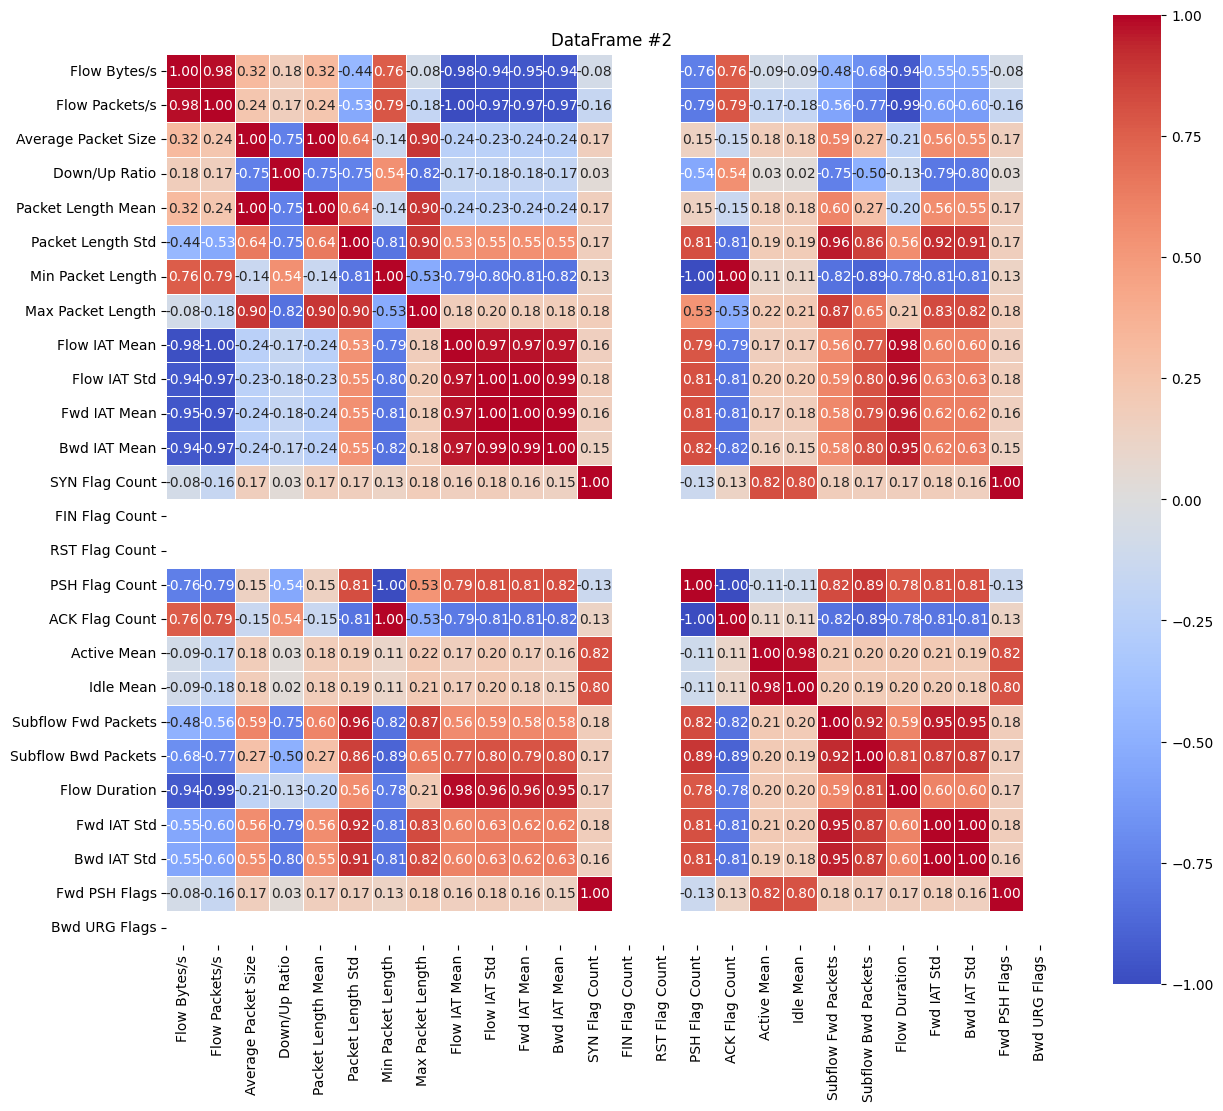

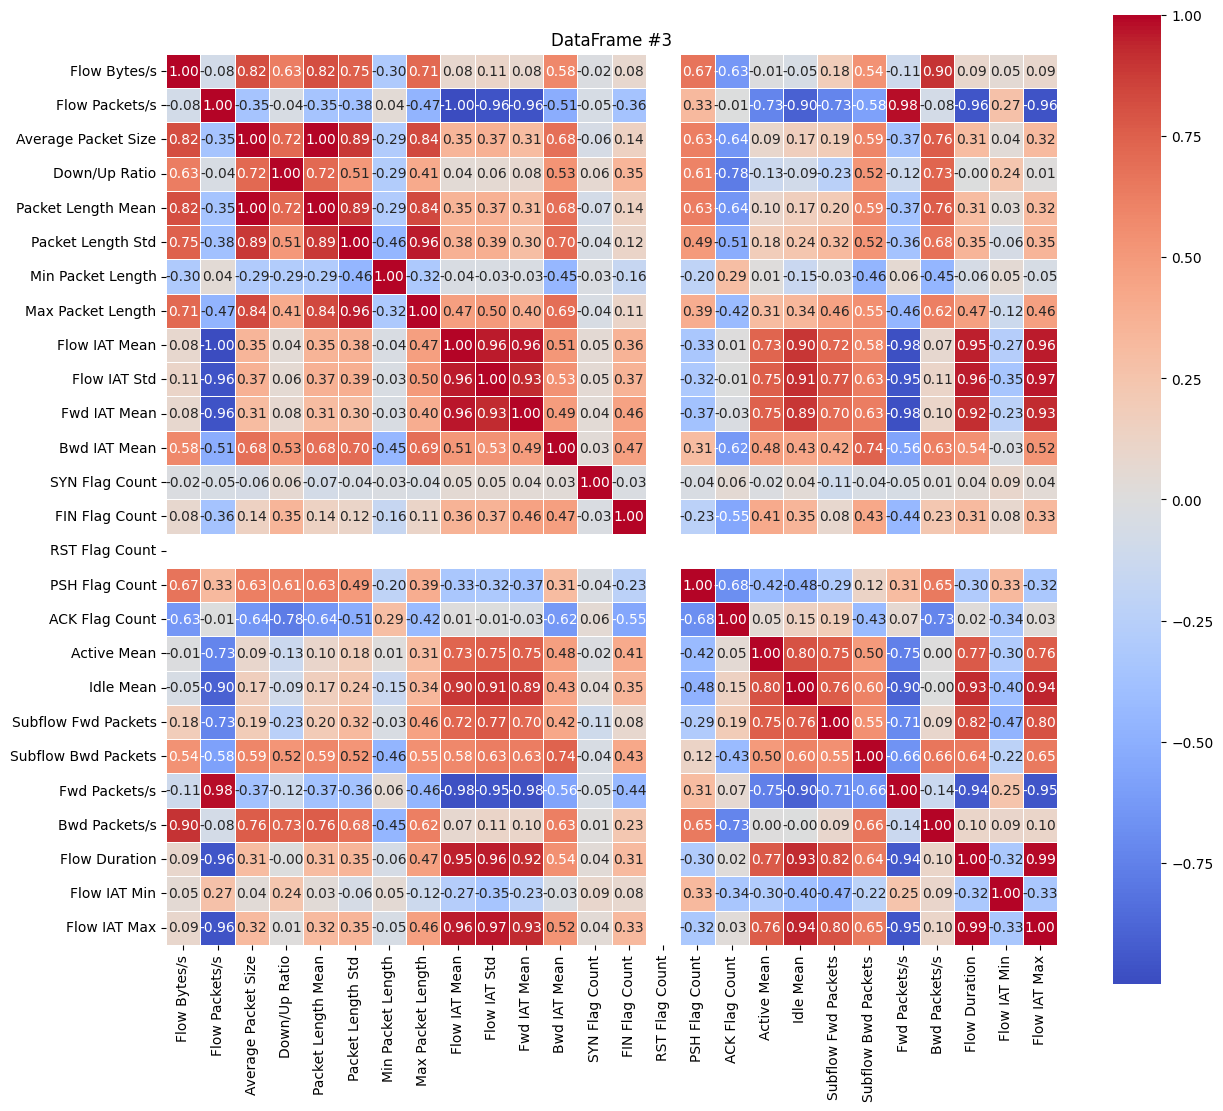

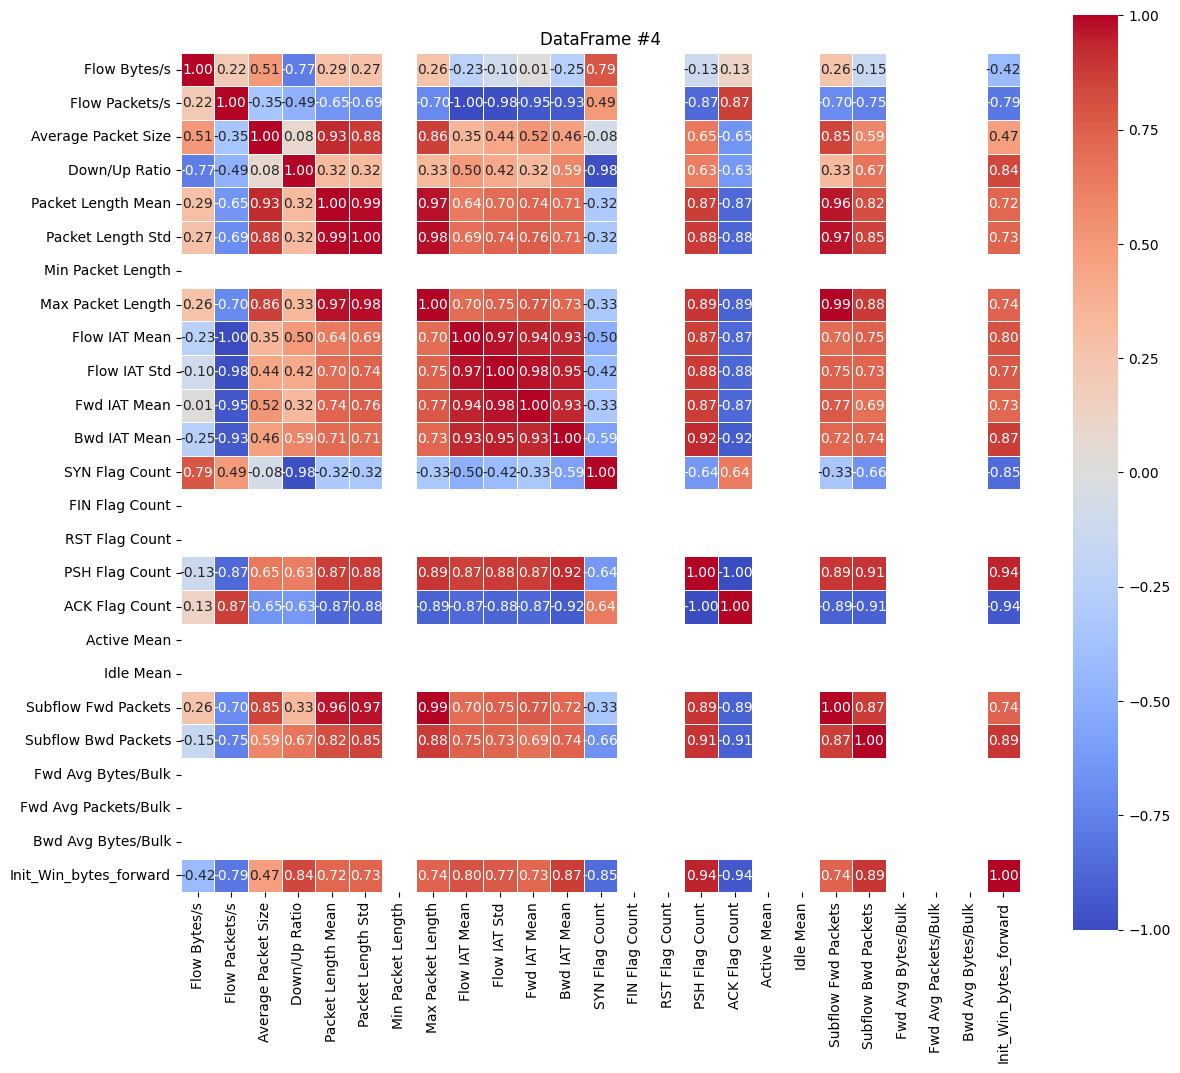

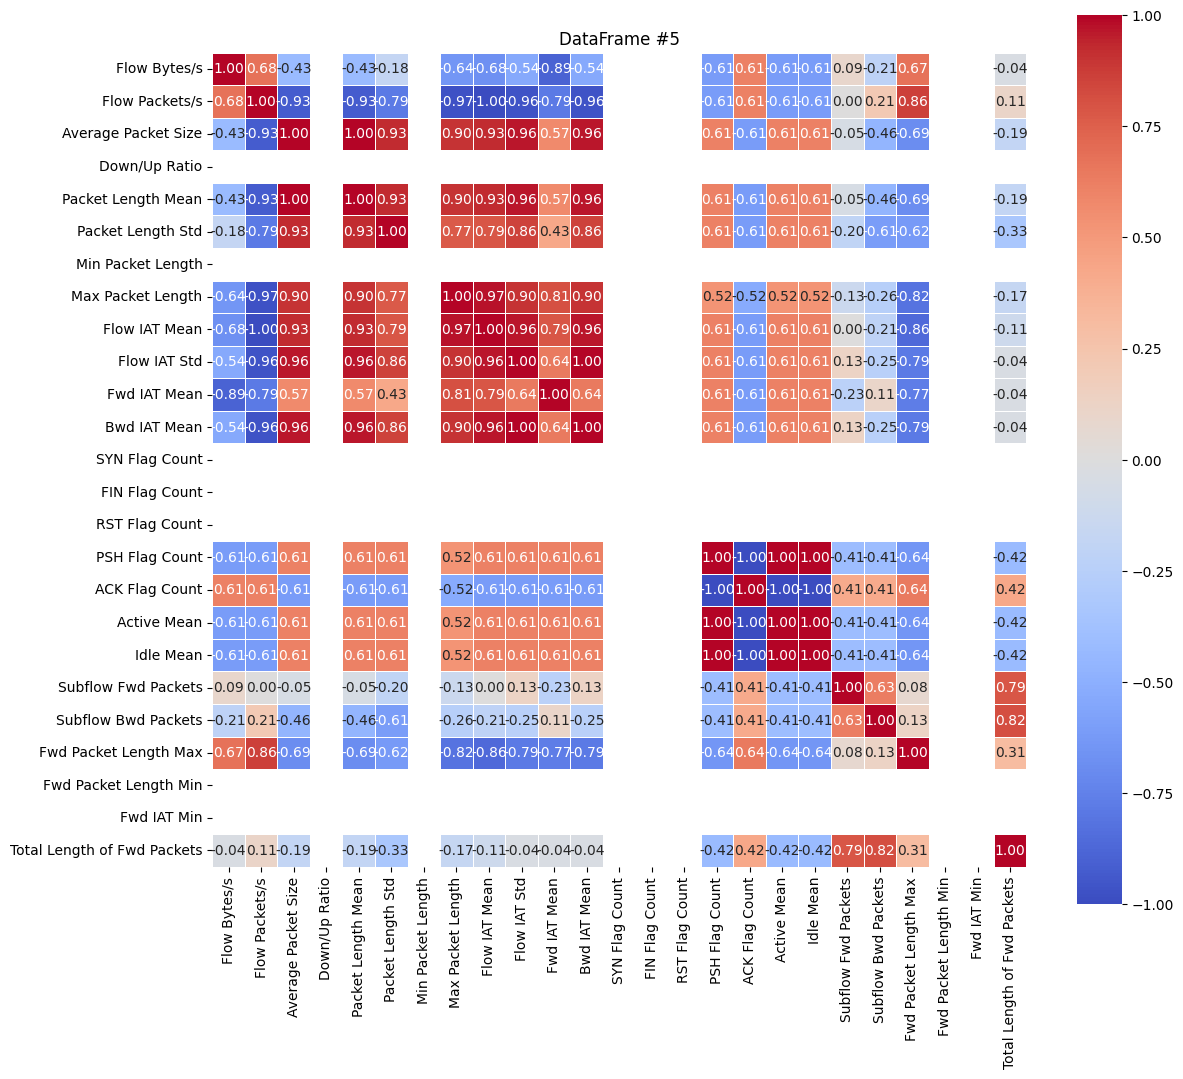

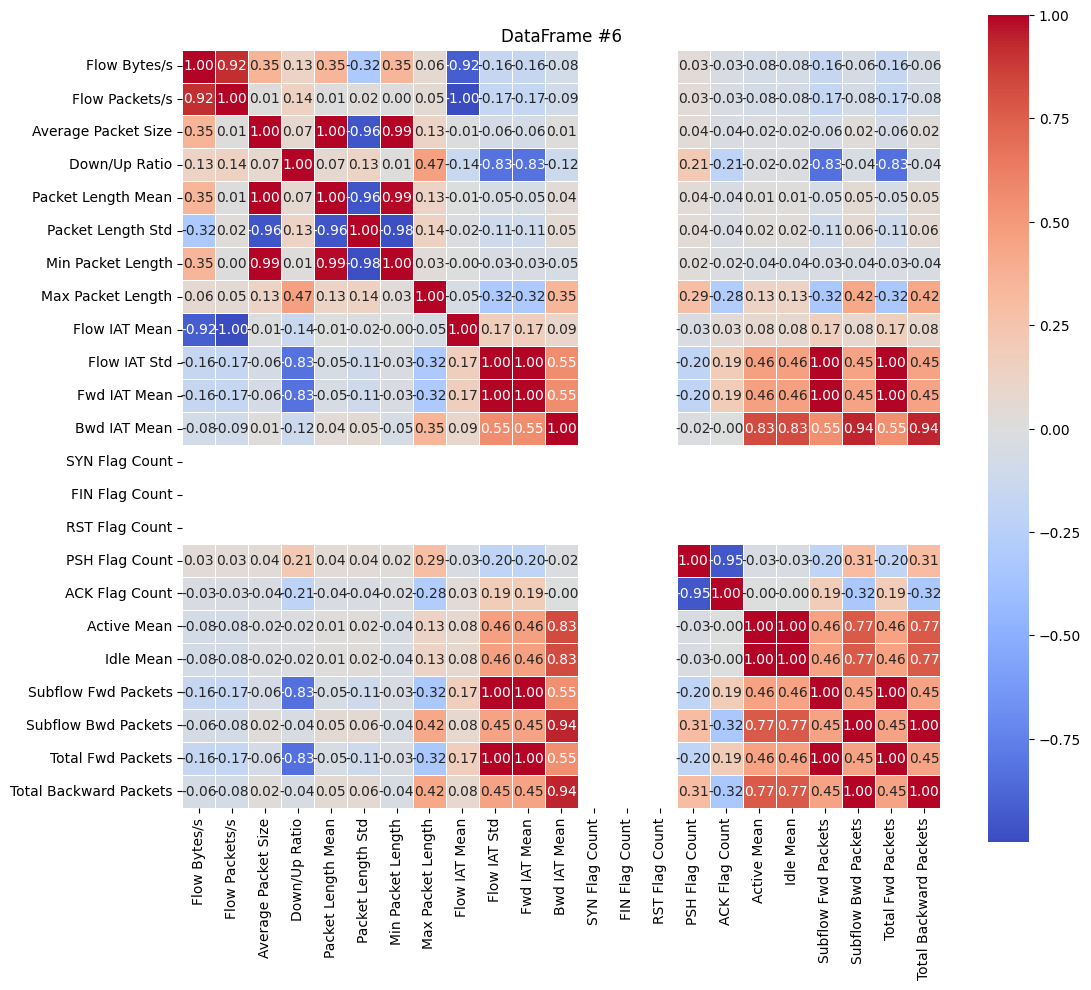

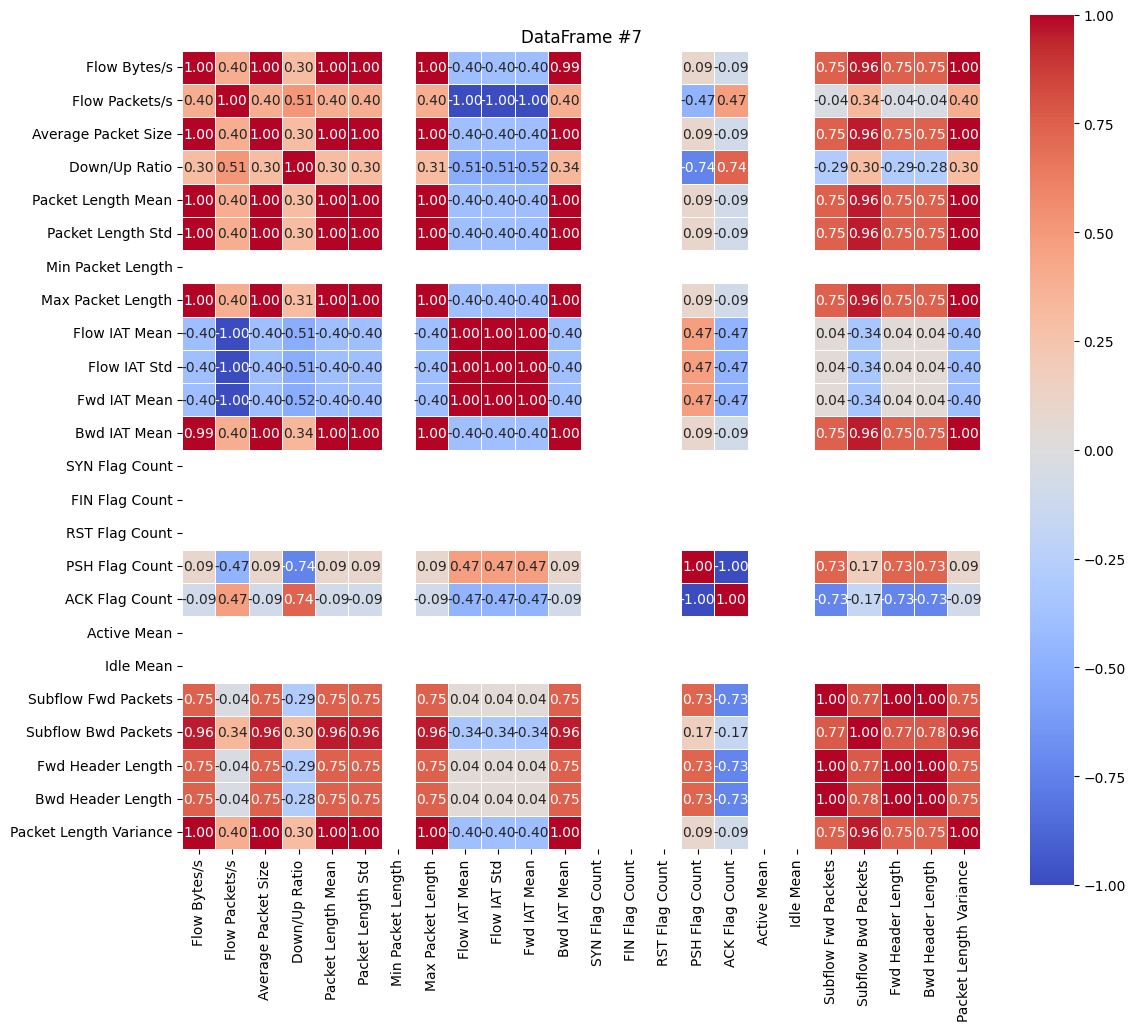

In [27]:
def plot_corr_heatmap(corr_df, title=None, cmap="coolwarm", annot=True, fmt=".2f"):
    plt.figure(figsize=(max(6, corr_df.shape[0] * 0.5), 
                        max(6, corr_df.shape[1] * 0.5)))
    sns.heatmap(
        corr_df,
        cmap=cmap,
        annot=annot,
        fmt=fmt,
        square=True,
        cbar_kws={"shrink": 0.8},
        linewidths=0.5
    )
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_all_heatmaps(corr_matrices, names=None):
    for i, corr_df in enumerate(corr_matrices, 1):
        title = names[i-1] if names and i-1 < len(names) else f"DataFrame #{i}"
        plot_corr_heatmap(corr_df, title=title)

plot_all_heatmaps(spearman_list)

In [23]:
spearman_list

[                     Flow Bytes/s  Flow Packets/s  Average Packet Size  \
 Flow Bytes/s             1.000000        0.581269             0.173915   
 Flow Packets/s           0.581269        1.000000            -0.494347   
 Average Packet Size      0.173915       -0.494347             1.000000   
 Down/Up Ratio            0.109978        0.051296             0.129335   
 Packet Length Mean       0.168462       -0.502589             0.993659   
 Packet Length Std        0.067221       -0.538182             0.919621   
 Min Packet Length        0.416273        0.102723             0.168679   
 Max Packet Length        0.114674       -0.551987             0.958987   
 Flow IAT Mean           -0.611101       -0.995969             0.466382   
 Flow IAT Std            -0.262324       -0.682732             0.454443   
 Fwd IAT Mean            -0.235996       -0.536280             0.291138   
 Bwd IAT Mean            -0.070466       -0.506262             0.558444   
 SYN Flag Count          

In [8]:
features_to_drop = [
    'Packet Length Std',
    'Max Packet Length',
    'Average Packet Size',
    'Flow IAT Std',
    'Fwd IAT Mean',
    'Bwd IAT Mean',
    'Fwd Header Length',
    'Bwd Header Length'
]

for df in binned_df:
    df.drop(columns=features_to_drop, errors='ignore', inplace=True)

In [24]:
df

,Flow Bytes/s,Flow Packets/s,Down/Up Ratio,Packet Length Mean,Min Packet Length,Flow IAT Mean,SYN Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,...,Label,dow,hour,dow_sin,dow_cos,hour_sin,hour_cos,Packet Length Variance,Fwd Header Length_bin,Packet Length Variance_bin
0,6.470381,1.308342,0.693147,5.411051,0.0,12.896356,0.0,0.0,0.0,1.0,...,Web Attack � Brute Force,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,11.606202,1,0
1,7.649746,1.472800,0.000000,6.381440,0.0,12.663772,0.0,0.0,0.0,1.0,...,Web Attack � Brute Force,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,14.164181,1,0
2,0.000000,10.114249,0.693147,0.000000,0.0,4.406719,0.0,0.0,0.0,0.0,...,Web Attack � Brute Force,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,0.000000,0,0
3,6.122759,1.186792,0.000000,5.223262,0.0,13.079861,0.0,0.0,0.0,1.0,...,Web Attack � Brute Force,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,11.598599,1,0
4,6.173003,1.160321,0.000000,5.304548,0.0,13.126484,0.0,0.0,0.0,1.0,...,Web Attack � Brute Force,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,11.659267,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175,6.262323,0.954849,0.000000,5.677134,0.0,13.480117,0.0,0.0,0.0,1.0,...,Web Attack � Sql Injection,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,13.039128,1,0
2176,6.853751,1.096383,0.693147,6.069898,0.0,13.231072,0.0,0.0,0.0,1.0,...,Web Attack � Sql Injection,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,13.554341,1,0
2177,6.261571,0.954385,0.693147,5.677134,0.0,13.480871,0.0,0.0,0.0,1.0,...,Web Attack � Sql Injection,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,13.039128,1,0
2178,0.000000,10.218235,0.693147,0.000000,0.0,4.304065,0.0,0.0,0.0,0.0,...,Web Attack � Sql Injection,3.0,9.0,0.433884,-0.900969,0.707107,-0.707107,0.000000,0,0


In [25]:
for i in binned_df:
    print(i.shape[0])

2268589
1991
374055
13826
7
158804
2180


In [9]:
category_labels = {
    'BENIGN': ['BENIGN'],
    'DoS': ['DDoS', 'DoS slowloris', 'DoS Hulk', 'DoS GoldenEye'],
    'PortScan': ['PortScan'],
    'Bot_Infiltration': ['Bot', 'Infiltration'],
    'Web': [
        'Web Attack � Brute Force',
        'Web Attack � XSS',
        'Web Attack � Sql Injection'
    ],
    'FTP_SSH_Patator': ['FTP-Patator', 'SSH-Patator'],
    'Heartbleed': ['Heartbleed']
}

base_features = [
    'Flow Bytes/s', 'Flow Packets/s', 'Average Packet Size', 'Down/Up Ratio',
    'Packet Length Mean', 'Packet Length Std', 'Min Packet Length', 'Max Packet Length',
    'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Mean', 'Bwd IAT Mean',
    'SYN Flag Count', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
    'Active Mean', 'Idle Mean', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 'Label', 'dow', 'hour', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos'
]

group_features = {
    'dos': [
        'Fwd Packets/s', 'Bwd Packets/s', 'Flow Duration',
        'Flow IAT Min', 'Flow IAT Max', 'SYN Flag Count', 'PSH Flag Count'
    ],
    'portscan': [
        'SYN Flag Count', 'FIN Flag Count', 'RST Flag Count',
        'Total Fwd Packets', 'Total Backward Packets'
    ],
    'bot_infiltration': [
        'Flow Duration', 'Fwd IAT Std', 'Bwd IAT Std',
        'Fwd PSH Flags', 'Bwd URG Flags', 'Down/Up Ratio'
    ],
    'web': [
        'Fwd Header Length', 'Bwd Header Length', 'Packet Length Variance',
        'ACK Flag Count', 'Average Packet Size'
    ],
    'ftp_ssh_patator': [
        'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Bwd Avg Bytes/Bulk',
        'Active Mean', 'Idle Mean', 'Init_Win_bytes_forward'
    ],
    'heartbleed': [
        'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd IAT Min',
        'Total Length of Fwd Packets', 'Packet Length Std'
    ]
}

In [10]:
label_mapping = {
    'BENIGN':            0,
    'DoS':               1,
    'PortScan':          2,
    'Bot_Infiltration':  3,
    'Web':               4,
    'FTP_SSH_Patator':   5,
    'Heartbleed':        6,
}

label_to_cat = {
    lbl: cat
    for cat, lbls in category_labels.items()
    for lbl in lbls
}
for df_sub in binned_df:
    df_sub['Category'] = df_sub['Label'].map(label_to_cat)

df = pd.concat(binned_df, ignore_index=True)
df['time'] = df['dow'] * 24 + df['hour'] 

cat_list = list(category_labels.keys())
label_mapping = {cat: i for i, cat in enumerate(cat_list)}

df['label_code'] = df['Category'].map(label_mapping)
df['composite']  = df['label_code'] * 168 + df['time']

extras = [f for feats in group_features.values() for f in feats]
all_feats = list(dict.fromkeys(base_features + extras))

for drop in ['Label','Category','dow','hour','dow_sin','dow_cos','hour_sin','hour_cos', 'Average Packet Size', 'Packet Length Std', 'Max Packet Length', 'Flow IAT Std', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Fwd Header Length', 'Bwd Header Length']:
    if drop in all_feats:
        all_feats.remove(drop)

df = df.fillna(0)

In [36]:
df.head()

,Flow Bytes/s,Flow Packets/s,Down/Up Ratio,Packet Length Mean,Min Packet Length,Flow IAT Mean,SYN Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,...,Total Fwd Packets,Total Backward Packets,Total Backward Packets_bin,Total Fwd Packets_bin,Packet Length Variance,Fwd Header Length_bin,Packet Length Variance_bin,time,label_code,composite
0,8.935391,4.221307,0.693147,4.725946,0.0,9.620893,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,0,109.0
1,8.894387,4.180912,0.693147,4.725946,0.0,9.661899,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,0,109.0
2,0.000000,9.433564,0.693147,0.000000,0.0,5.081404,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,0,109.0
3,8.879510,4.169379,0.693147,4.722530,0.0,9.673898,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,0,109.0
4,0.000000,10.570343,1.098612,0.000000,0.0,3.676301,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,0,109.0


In [12]:
X = df[all_feats]
y = df['label_code']
c = df['composite']

X_temp, X_test, y_temp, y_test, c_temp, c_test = train_test_split(
    X, y, c,
    test_size=0.15,
    stratify=c,
    random_state=42
)

X_train, X_val, y_train, y_val, c_train, c_val = train_test_split(
    X_temp, y_temp, c_temp,
    test_size=0.12,
    stratify=c_temp,
    random_state=42
)

counts = y_train.value_counts()
min_count = counts.min()
k = max(1, min(min_count - 1, 5))
print(f"SMOTE буде використовувати k_neighbors={k} (мінімум прикладів у класі = {min_count})")

sm = SMOTE(k_neighbors=k, random_state=1)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)


from collections import Counter
print("TRAIN класів:", Counter(y_train_bal))
print("VAL   класів:", Counter(y_val))
print("TEST  класів:", Counter(y_test))
print("TRAIN часів:", Counter(c_train % 168))
print("VAL   часів:", Counter(c_val   % 168))
print("TEST  часів:", Counter(c_test  % 168))

SMOTE буде використовувати k_neighbors=4 (мінімум прикладів у класі = 5)
TRAIN класів: Counter({0: 1696904, 1: 1696904, 4: 1696904, 2: 1696904, 5: 1696904, 3: 1696904, 6: 1696904})
VAL   класів: Counter({0: 231396, 1: 38154, 2: 16198, 5: 1410, 4: 222, 3: 204, 6: 1})
TEST  класів: Counter({0: 340289, 1: 56108, 2: 23821, 5: 2074, 4: 327, 3: 298, 6: 1})
TRAIN часів: Counter({60.0: 512498, 12.0: 395651, 36.0: 332957, 87.0: 215455, 109.0: 213868, 113.0: 168750, 105.0: 142633, 81.0: 127137})
VAL   часів: Counter({60.0: 69886, 12.0: 53953, 36.0: 45403, 87.0: 29381, 109.0: 29164, 113.0: 23012, 105.0: 19450, 81.0: 17336})
TEST  часів: Counter({60.0: 102773, 12.0: 79342, 36.0: 66770, 87.0: 43206, 109.0: 42888, 113.0: 33841, 105.0: 28603, 81.0: 25495})


In [19]:
X_train_bal.to_csv('..//NN Datasets//x_train.csv')
y_train_bal.to_csv('..//NN Datasets//y_train.csv')

X_val.to_csv('..//NN Datasets//x_val.csv')
y_val.to_csv('..//NN Datasets//y_val.csv')

X_test.to_csv('..//NN Datasets//x_test.csv')
y_test.to_csv('..//NN Datasets//y_test.csv')